In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import bz2
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [44]:
# Members of the intersection of both the 115th and 116th US Congress
# All of these members where there during the whole 2016-2020 period (both 115th & 116th congress)
congress = pd.read_csv("/content/drive/MyDrive/ADA/congress_115_116.csv")

In [45]:
congress.head()

,Unnamed: 0,fec_candidate_id,speaker,short_title,last_name,first_name,party,date_of_birth,gender,state
0,0,H4LA05221,ralph abraham,Rep.,Abraham,Ralph,R,1954-09-16,M,LA
1,1,H4NC12100,alma adams,Rep.,Adams,Alma,D,1946-05-27,F,NC
2,2,H6AL04098,robert aderholt,Rep.,Aderholt,Robert,R,1965-07-22,M,AL
3,3,H2CA31125,pete aguilar,Rep.,Aguilar,Pete,D,1979-06-19,M,CA
4,4,H2GA12121,rick allen,Rep.,Allen,Rick,R,1951-11-07,M,GA


In [46]:
%%time 
# link to the Drive repo + the year of the newpapers quotes
path_to_file = '/content/drive/MyDrive/ADA/quotes-2016-congress-speakers.json.bz2'
# here the data is in the ADA folder placed at the root of your Drive

quotes_2016_congress = []
with bz2.open(path_to_file, 'rb') as s_file:
    for i, sample in enumerate(s_file):
      quote = json.loads(sample)
      quotes_2016_congress.append(quote)

CPU times: user 15.3 s, sys: 356 ms, total: 15.7 s
Wall time: 15.6 s


In [47]:
# Transforming the array of quotes in a pandas DataFrame
df_2016_congress = pd.DataFrame(quotes_2016_congress)
df_2016_congress.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2016-07-21-005544,"All the police officers that we work with, we ...",Frederica Wilson,[Q461504],2016-07-21 17:01:00,1,"[[Frederica Wilson, 0.8788], [None, 0.1212]]",[http://www.washingtontimes.com/news/2016/jul/...,E
1,2016-07-23-004668,"As a former Christian missionary, faith is cen...",Tim Kaine,[Q359888],2016-07-23 18:06:44,8,"[[Tim Kaine, 0.5755], [None, 0.2272], [Larry R...",[https://www.buzzfeed.com/andrewkaczynski/list...,E
2,2016-09-09-010924,bad bill that would put Americans' savings and...,Maxine Waters,[Q461727],2016-09-09 21:58:45,6,"[[Maxine Waters, 0.922], [None, 0.0728], [Jim ...",[http://thehour.com/business/article/Himes-fav...,E
3,2016-09-28-013218,"Better deal how? What exactly is your idea, Do...",Elizabeth Warren,[Q434706],2016-09-28 08:34:00,2,"[[Elizabeth Warren, 0.5615], [None, 0.3314], [...",[http://www.politico.com/story/2016/09/warren-...,E
4,2016-05-02-010790,"But that's the free market,",Seth Moulton,[Q18045052],2016-05-02 19:11:11,2,"[[Seth Moulton, 0.3773], [None, 0.2566], [Dona...",[http://gloucestertimes.com/news/local_news/mo...,E


In [48]:
# Counting the number of quotes by each member of the congress
df_2016_congress["speaker"].str.lower().value_counts()

ted cruz            10842
marco rubio          6716
tim kaine            5991
elizabeth warren     3333
mitch mcconnell      3116
                    ...  
david per               1
e murphy                1
susan bro               1
e clarke                1
lisa b                  1
Name: speaker, Length: 408, dtype: int64

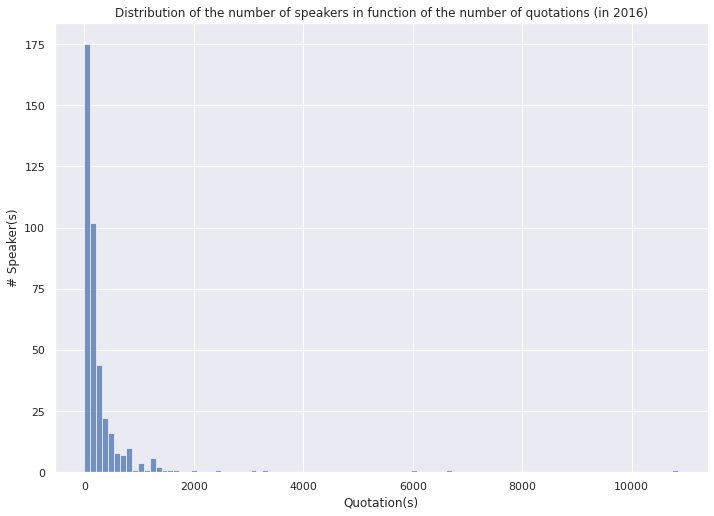

CPU times: user 665 ms, sys: 19.3 ms, total: 685 ms
Wall time: 669 ms


In [49]:
%%time
# Distribution of the number(#) of speakers in function of the # of quotes

ax11 = sns.histplot(data = df_2016_congress["speaker"].str.lower().value_counts(), bins=100)
ax11.set_title('Distribution of the number of speakers in function of the number of quotations (in 2016)')
ax11.set_ylabel('# Speaker(s)')
ax11.set_xlabel('Quotation(s)')
plt.show()

In [50]:
df_2016_congress["speaker"] = df_2016_congress["speaker"].str.lower()
df_2016_congress_merged = pd.merge(df_2016_congress, congress[["speaker", "party", "gender", "date_of_birth", 'state']], on=["speaker"], how='left')
df_2016_congress_merged.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,party,gender,date_of_birth,state
0,2016-07-21-005544,"All the police officers that we work with, we ...",frederica wilson,[Q461504],2016-07-21 17:01:00,1,"[[Frederica Wilson, 0.8788], [None, 0.1212]]",[http://www.washingtontimes.com/news/2016/jul/...,E,D,F,1942-11-05,FL
1,2016-07-23-004668,"As a former Christian missionary, faith is cen...",tim kaine,[Q359888],2016-07-23 18:06:44,8,"[[Tim Kaine, 0.5755], [None, 0.2272], [Larry R...",[https://www.buzzfeed.com/andrewkaczynski/list...,E,D,M,1958-02-26,VA
2,2016-09-09-010924,bad bill that would put Americans' savings and...,maxine waters,[Q461727],2016-09-09 21:58:45,6,"[[Maxine Waters, 0.922], [None, 0.0728], [Jim ...",[http://thehour.com/business/article/Himes-fav...,E,D,F,1938-08-15,CA
3,2016-09-28-013218,"Better deal how? What exactly is your idea, Do...",elizabeth warren,[Q434706],2016-09-28 08:34:00,2,"[[Elizabeth Warren, 0.5615], [None, 0.3314], [...",[http://www.politico.com/story/2016/09/warren-...,E,D,F,1949-06-22,MA
4,2016-05-02-010790,"But that's the free market,",seth moulton,[Q18045052],2016-05-02 19:11:11,2,"[[Seth Moulton, 0.3773], [None, 0.2566], [Dona...",[http://gloucestertimes.com/news/local_news/mo...,E,D,M,1978-10-24,MA


In [51]:
# Number of quotes for this dataset
quotes_number_2016 = df_2016_congress_merged.shape[0]
print(f' Total number of quotes for congress dataset 2016: {quotes_number_2016}')

 Total number of quotes for congress dataset 2016: 125541


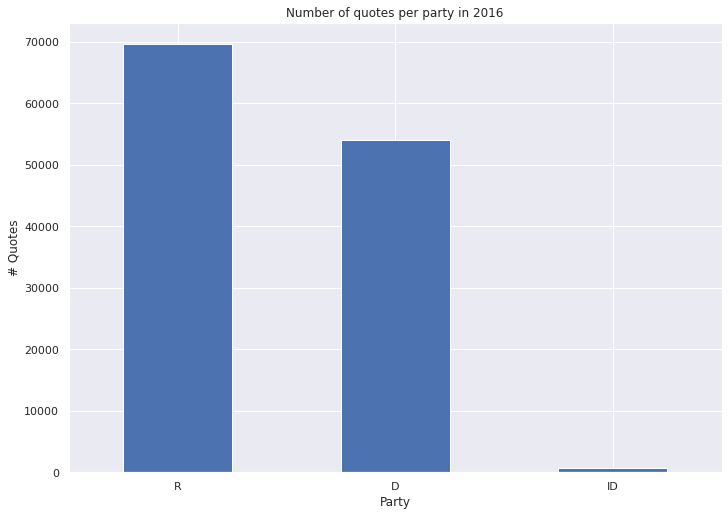

,party
R,69648
D,54040
ID,678


In [52]:
#-------------------Political party------------------------

df_party = df_2016_congress_merged['party'].value_counts().to_frame()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax2 = df_party.plot(kind='bar', rot=0, legend = False)
ax2.set_title("Number of quotes per party in 2016")
ax2.set_ylabel('# Quotes')
ax2.set_xlabel('Party')
plt.show()
df_party

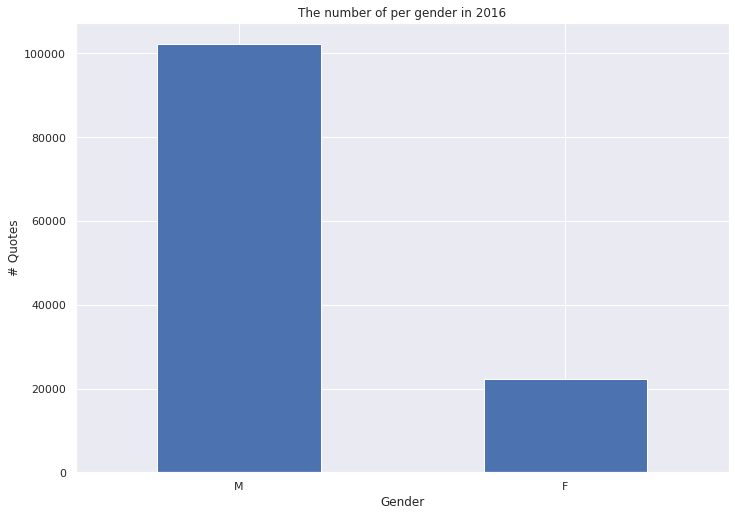

,gender
M,102194
F,22172


In [53]:
#-----------------Gender-----------------

df_gender = df_2016_congress_merged['gender'].value_counts().to_frame()
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax3 = df_gender.plot(kind='bar', rot=0, legend = False)
ax3.set_title('The number of per gender in 2016')
ax3.set_ylabel('# Quotes')
ax3.set_xlabel('Gender')
plt.show()
df_gender

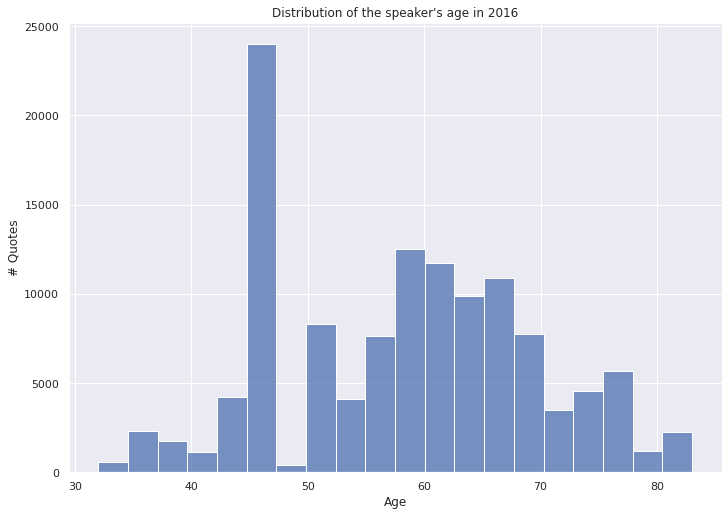

,age
mean,58.145691
50%,58.000000
min,32.000000
max,83.000000


In [54]:
#-----------------Age-----------------

df_2016_congress_merged['year_of_birth'] = pd.DatetimeIndex(df_2016_congress_merged['date_of_birth']).year.astype('Int64')
df_2016_congress_merged['age'] = (2016 - df_2016_congress_merged['year_of_birth']).astype('Int64')
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax3 = sns.histplot(data = df_2016_congress_merged['age'], bins=20)
ax3.set_title("Distribution of the speaker's age in 2016")
ax3.set_ylabel('# Quotes')
ax3.set_xlabel('Age')
plt.show()

df_2016_congress_merged.describe().loc[['mean', '50%', 'min', 'max'],['age']]


     |████████████████████████████████| 1.0 MB 8.4 MB/s 
     |████████████████████████████████| 15.4 MB 37 kB/s 
     |████████████████████████████████| 6.3 MB 26.4 MB/s 


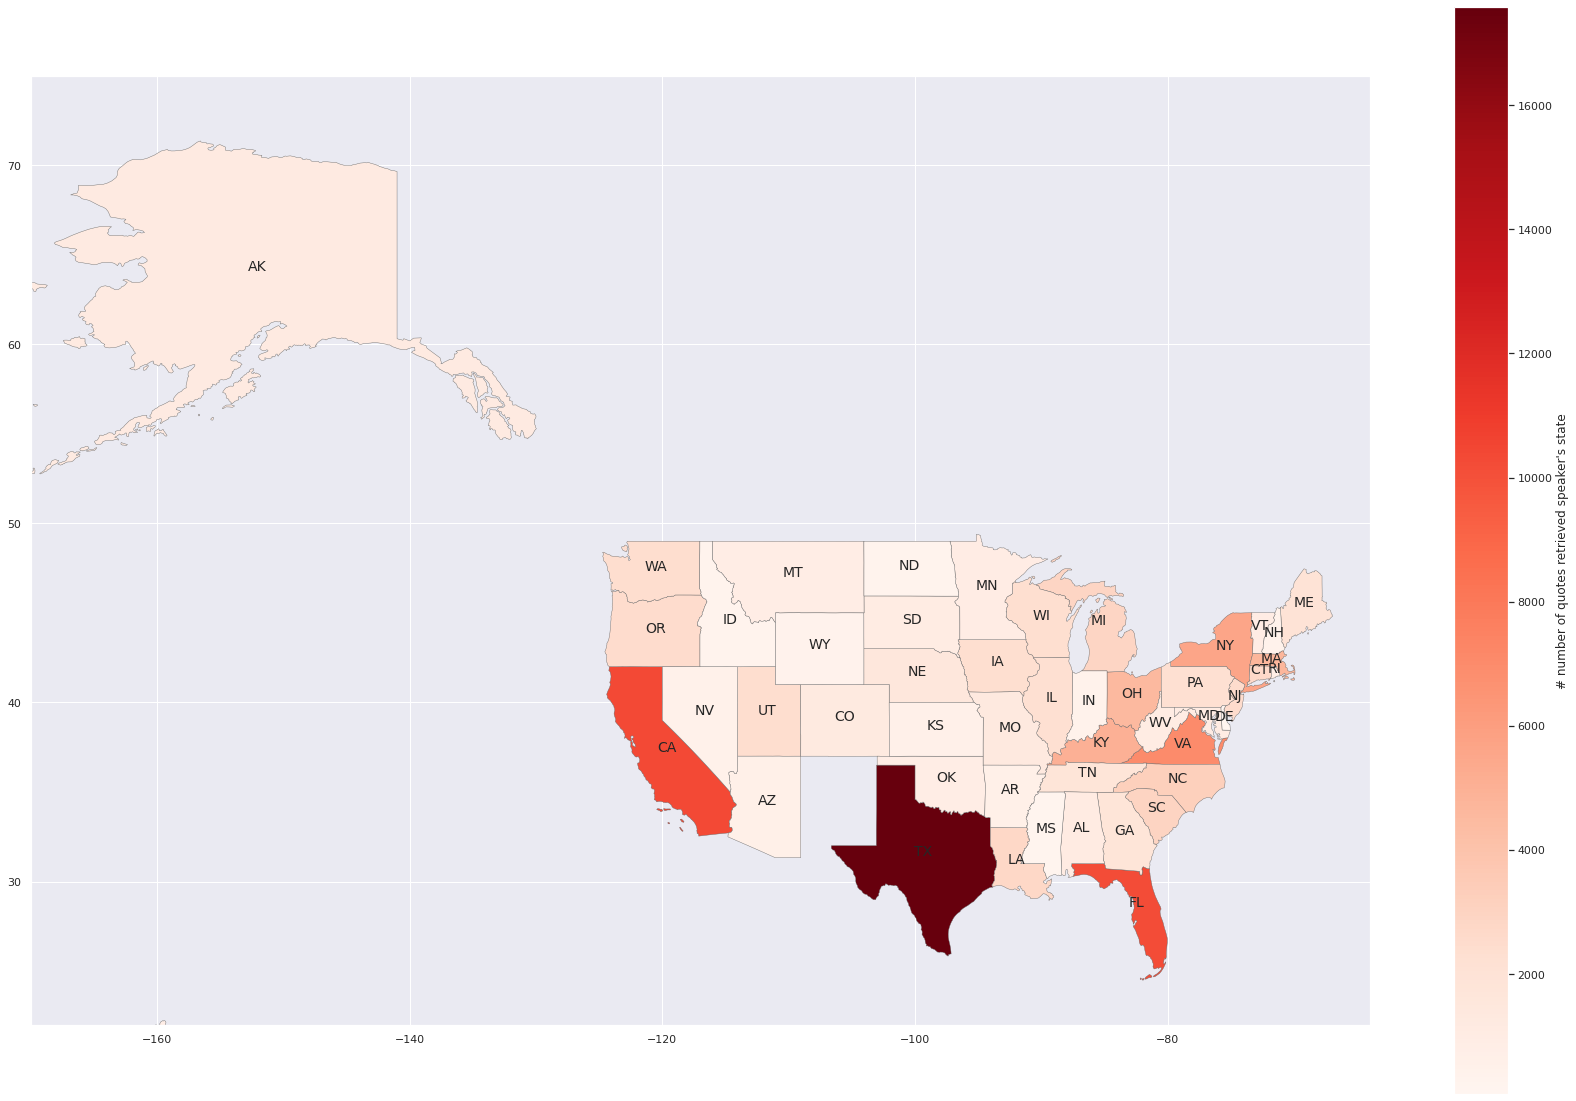

In [56]:
#--------------------State-----------------------
# Heatmap of occurences of state origin of speaker 
!pip install geopandas #to run once
import geopandas as gpd
from geopandas import GeoDataFrame
states_map = gpd.read_file("/content/drive/MyDrive/map/cb_2018_us_state_20m.shp")

fig, ax = plt.subplots(1, figsize=(30, 20))
df_state = df_2016_congress_merged['state'].value_counts().to_frame()
merged = df_state.merge(states_map, left_index=True, right_on='STUSPS')
merged = GeoDataFrame(merged)
merged.apply(lambda x: ax.annotate(s=x.STUSPS, xy=x.geometry.centroid.coords[0], ha='center', fontsize=14),axis=1);
merged.plot(column="state", cmap="Reds", ax=ax, linewidth=0.4, edgecolor=".4", legend=True, legend_kwds={'label': "# number of quotes retrieved speaker's state", 'orientation': "vertical"})
_ = ax.set_xlim([-170, -64])
_ = ax.set_ylim([22, 75])


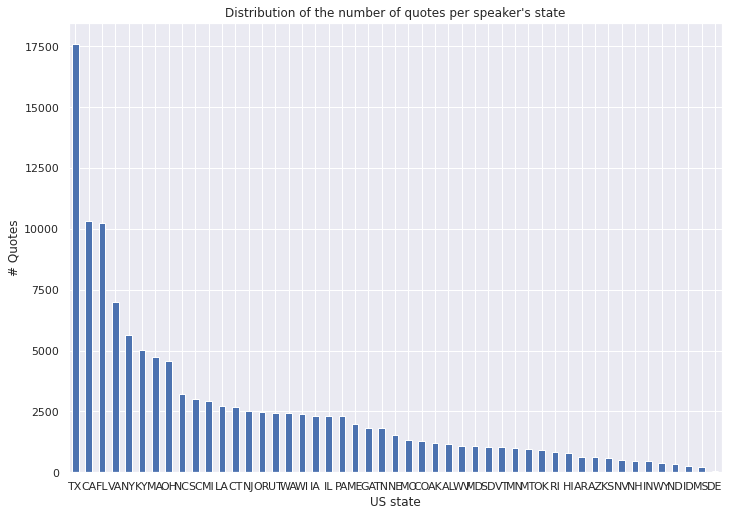

In [57]:
ax2 = df_state.plot(kind='bar', rot=0, legend = False)
ax2.set_title("Distribution of the number of quotes per speaker's state")
ax2.set_ylabel('# Quotes')
ax2.set_xlabel('US state')
plt.show()

In [58]:
# Number of quotes containing the string "climate change"

num_quotes_climate_change = np.count_nonzero(df_2016_congress_merged['quotation'].str.count('climate change'), axis=0)
print(f'Number of quotes containing the string "climate change": {num_quotes_climate_change}')

Number of quotes containing the string "climate change": 248


In [59]:
# Number of quotes containing the string 'Paris agreement'

num_quotes_paris = np.count_nonzero(df_2016_congress_merged['quotation'].str.count('Paris agreement'), axis=0)
print(f'Number of quotes containing the string "Paris agreement": {num_quotes_paris}')

Number of quotes containing the string "Paris agreement": 2


In [60]:
# Number of quotes containing the string "health insurances"

num_quotes_health_insurance = np.count_nonzero(df_2016_congress_merged['quotation'].str.count('health insurance'), axis=0)
print(f'Number of quotes containing the string "health insurances": {num_quotes_health_insurance}')

Number of quotes containing the string "health insurances": 93
